# Notes

## Install and Import

In [1]:
!pip install pytorch-pretrained-bert pytorch-nlp
!pip install tensorflow

In [2]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from transformers import BertTokenizer, BertForSequenceClassification, get_linear_schedule_with_warmup  # CHANGED: removed AdamW
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from tqdm import trange

In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

'Tesla T4'

## Load Dataset


In [4]:
df = pd.read_csv(r'/content/train_data.csv', header=0)

In [5]:
# Encode labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(df['Target'])

# Prepare texts with special tokens
Texts = ["[CLS] " + text + " [SEP]" for text in df.Text.values]

## Inputs

Next, import the BERT tokenizer, used to convert our text into tokens that correspond to BERT's vocabulary.

In [6]:
# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Tokenize texts
tokenized_texts = [tokenizer.tokenize(sent) for sent in Texts]
print("Tokenize the first Text:")
print(tokenized_texts[0])

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:104: UserWarning: 
Error while fetching `HF_TOKEN` secret value from your vault: 'Requesting secret HF_TOKEN timed out. Secrets can only be fetched when running from the Colab UI.'.
You are not authenticated with the Hugging Face Hub in this notebook.
If the error persists, please let us know by opening an issue on GitHub (https://github.com/huggingface/huggingface_hub/issues/new).
  warnings.warn(


Tokenize the first Text:
['[CLS]', 'jeff', 'bo', '##zo', 'have', 'decide', 'he', 'will', 'not', 'end', 'world', 'hunger', 'today', '[SEP]']


In [7]:
MAX_LEN = 512
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")


Create the attention masks

In [8]:
# Attention masks
attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

In [9]:
# Train-validation split
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=2018, test_size=0.1
)
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, input_ids, random_state=2018, test_size=0.1
)

In [10]:
# Convert to torch tensors
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [11]:
# DataLoader
batch_size = 16
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)


## Train Model

In [12]:
# Load BERT model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)
model.to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [13]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)

In [14]:
# Learning rate scheduler
epochs = 3
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps
)
# -------------------------------------

# Accuracy function
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

# Training
train_loss_set = []

for epoch in trange(epochs, desc="Epoch"):
    model.train()
    tr_loss = 0
    nb_tr_steps = 0

    for step, batch in enumerate(train_dataloader):
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        optimizer.zero_grad()
        outputs = model(input_ids=b_input_ids,
                        attention_mask=b_input_mask,
                        labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits

        train_loss_set.append(loss.item())
        loss.backward()
        optimizer.step()
        scheduler.step()

        tr_loss += loss.item()
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss / nb_tr_steps))

    # Validation
    model.eval()
    eval_accuracy = 0
    nb_eval_steps = 0

    for batch in validation_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch

        with torch.no_grad():
            outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
            logits = outputs.logits  # Modern HuggingFace returns a ModelOutput object

        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy / nb_eval_steps))

Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.4270021602646871


Epoch:  33%|███▎      | 1/3 [06:48<13:36, 408.41s/it]

Validation Accuracy: 0.9101702508960574
Train loss: 0.14724972019141372


Epoch:  67%|██████▋   | 2/3 [13:37<06:48, 408.79s/it]

Validation Accuracy: 0.9218189964157706
Train loss: 0.06813091299242593


Epoch: 100%|██████████| 3/3 [20:26<00:00, 408.81s/it]

Validation Accuracy: 0.9218189964157706


In [15]:
# Save model and tokenizer
model.save_pretrained('./saved_bert_model')
tokenizer.save_pretrained('./saved_bert_model')

import shutil
import os

# Zip the saved model directory
shutil.make_archive('bert_model', 'zip', 'saved_bert_model')

from google.colab import files

# Download the zip file to your local machine
files.download('bert_model.zip')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training Evaluation

Let's take a look at our training loss over all batches:

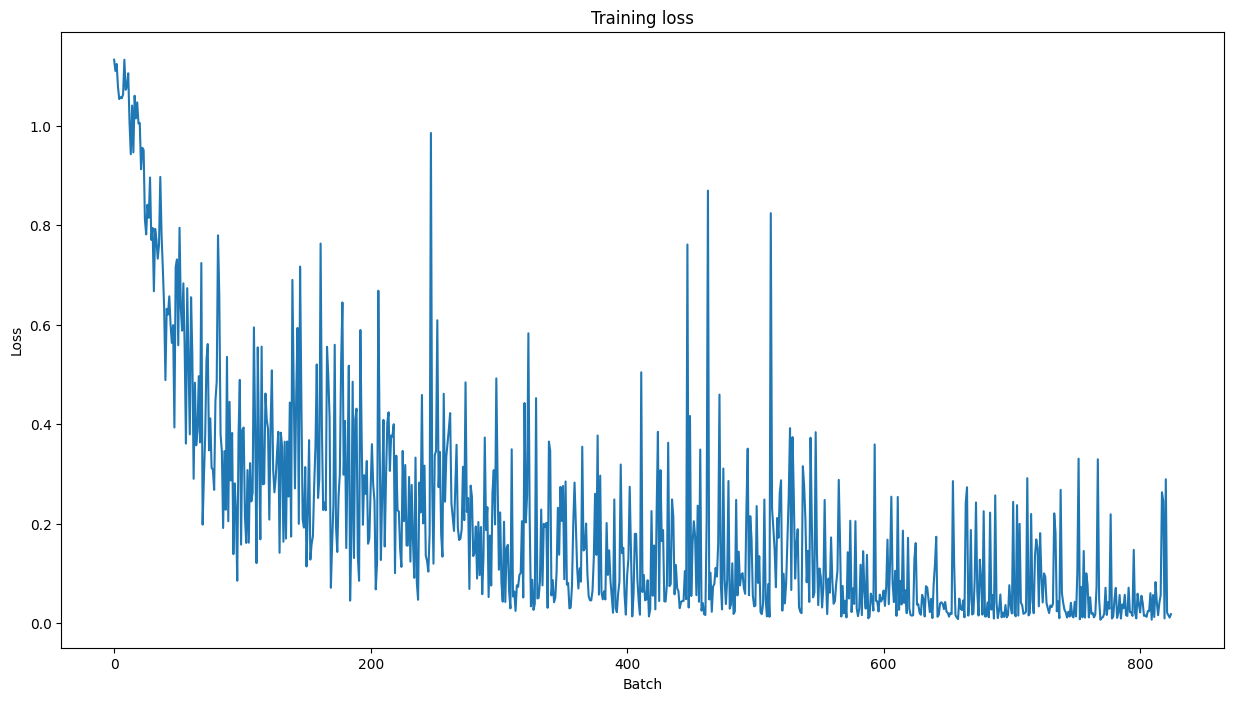

In [16]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()

##Predict and Evaluate on Holdout Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

In [17]:


df = pd.read_csv(r'/content/test_data.csv', header=0)

# --- REMOVED: don't re-fit a new LabelEncoder() here ---
# label_encoder = LabelEncoder()               # REMOVED
# test_labels = label_encoder.fit_transform(df['Target'])
# Use the label_encoder from training instead:
test_labels = label_encoder.transform(df['Target'].values)  # CHANGED

# Prepare texts with special tokens (same as you did in training)
Texts = ["[CLS] " + text + " [SEP]" for text in df.Text.values]

tokenized_texts = [tokenizer.tokenize(sent) for sent in Texts]

MAX_LEN = 512  # CHANGED? training used 128; OK to keep 256 but no new info past 128 if trained w/128

# Token IDs + padding
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

# Attention masks
attention_masks = [[float(i > 0) for i in seq] for seq in input_ids]

# Torch tensors
prediction_inputs  = torch.tensor(input_ids, dtype=torch.long)         # CHANGED: explicit dtype
prediction_masks   = torch.tensor(attention_masks, dtype=torch.long)   # CHANGED: explicit dtype
prediction_labels  = torch.tensor(test_labels, dtype=torch.long)       # CHANGED: explicit dtype

# DataLoader
batch_size = 16
prediction_data = TensorDataset(prediction_inputs, prediction_masks, prediction_labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)


In [18]:
model.eval()
predictions = []   # will hold one row per example
true_labels = []

for batch in prediction_dataloader:
    b_input_ids, b_input_mask, b_labels = [t.to(device) for t in batch]  # CHANGED: unpack directly

    with torch.no_grad():
        outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask)
        logits = outputs.logits  # CHANGED: proper extraction

    logits = logits.detach().cpu().numpy()
    labels_np = b_labels.detach().cpu().numpy()

    predictions.extend(logits)    # CHANGED: extend (was append)
    true_labels.extend(labels_np) # CHANGED: extend (was append)

# Convert to arrays
predictions = np.array(predictions)  # shape (N, num_labels)
true_labels = np.array(true_labels)  # shape (N,)

# Predicted class indices
pred_ids = np.argmax(predictions, axis=1)

# Map back to original class names
pred_labels = label_encoder.inverse_transform(pred_ids)  # CHANGED: safe now

# Attach to df and preview
df["predicted_label"] = pred_labels
display(df.head())  # or df.head()

,Text,Target,predicted_label
0,study need set nothing service ready productio...,0.0,0.0
1,wrinkle be just stale for clothes,1.0,1.0
2,i be an go to me shoot you,2.0,2.0
3,reflect back on the past again and look far ahead,0.0,0.0
4,side one the phone call with missouri departme...,2.0,2.0


Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      0.90      0.90       411
         1.0       0.90      0.87      0.89       409
         2.0       0.94      0.99      0.96       401

    accuracy                           0.92      1221
   macro avg       0.92      0.92      0.92      1221
weighted avg       0.92      0.92      0.92      1221



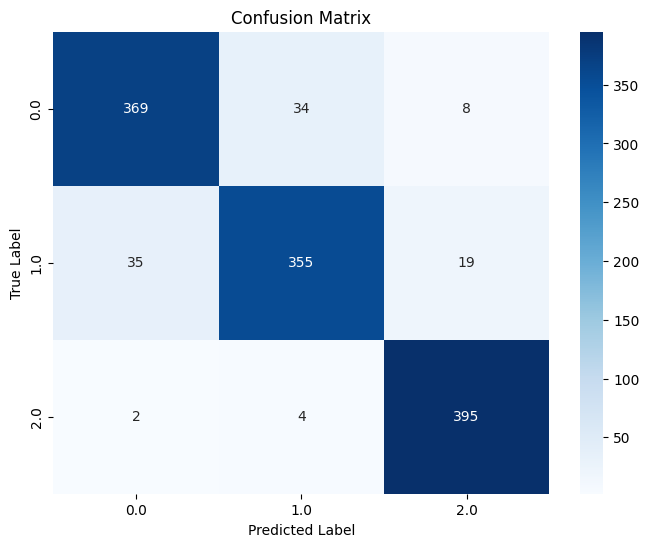

In [20]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
print("Classification Report:")
print(classification_report(true_labels, pred_ids,
                            target_names=[str(c) for c in label_encoder.classes_]))

cm = confusion_matrix(true_labels, pred_ids)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[str(c) for c in label_encoder.classes_],
            yticklabels=[str(c) for c in label_encoder.classes_])
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


In [21]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Accuracy
accuracy = accuracy_score(true_labels, pred_ids)

# Weighted Precision, Recall, F1
precision, recall, f1, _ = precision_recall_fscore_support(
    true_labels, pred_ids, average='weighted'
)

print(f"Accuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")

Accuracy:  0.9165
Precision: 0.9159
Recall:    0.9165
F1 Score:  0.9159


After running the cell above, you can download the saved model file (`pytorch_model.bin`) from the file browser on the left sidebar in Google Colab.